In [1]:
# Only needed in pycharm
import os

os.chdir('/home/cs-folq1/src/sts_bert/sBERT')

In [2]:
import torch

from Datasets import load_sts, load_paws_wiki
from CrossEncoder import CrossEncoder, CrossEncoderPretrained
from BiEncoder import BiEncoder
from PawsTrainer import PawsTrainer
from GridRun import GridRun, random_sample

In [3]:
# Load datasets.

datasets_path = '/home/cs-folq1/rds/rds-t2-cspp025-5bF3aEHVmLU/cs-folq1/datasets/'
# datasets_path = '/home/david/Documents/PhD/rds/datasets/'
sts_dataset = load_sts()
paws_dataset = load_paws_wiki(datasets_path=datasets_path)


Reusing dataset stsb_multi_mt (/home/cs-folq1/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/bc6de0eaa8d97c28a4c22a07e851b05879ae62c60b0b69dd6b331339e8020f07)
Using custom data configuration default-d611463bc29ee5be
Reusing dataset csv (/home/cs-folq1/.cache/huggingface/datasets/csv/default-d611463bc29ee5be/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
Using custom data configuration default-74d1f369bad8100c
Reusing dataset csv (/home/cs-folq1/.cache/huggingface/datasets/csv/default-74d1f369bad8100c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
Using custom data configuration default-1e28d5ed0ea0f0e7
Reusing dataset csv (/home/cs-folq1/.cache/huggingface/datasets/csv/default-1e28d5ed0ea0f0e7/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


In [4]:
# # Train original cross encoder.
#
# sts_model = CrossEncoder(mode='cls-pooling-hidden')
# # sts_model = CrossEncoder(mode='cls-pooling-hidden', bert_model='bert-base-uncased')
#
# sts_trainer = STSTrainer(model=sts_model, train_dataset=sts_dataset['train'],
#                          dataset=sts_dataset, num_epochs=10, lr_scheduler='linear',
#                          warmup_percent=0.2)
# sts_trainer.train(disable_progress_bar=True)
# #original_sts_cross_model_path = './saved_models/few_shot_paws/original_cross_encoder.bin'
# #torch.save(sts_model.state_dict(), original_sts_cross_model_patcross_h)


In [4]:
original_sts_cross_model_path = \
    'results/pretraining_sts/results_210702_094435_cross-encoder_cls-pooling-hidden_best_model.bin'
original_nli_sts_cross_model_path = \
    'results/pretraining_sts/results_210702_094435_cross-encoder_nli-base_best_model.bin'
original_sts_bi_model_path = \
    'results/pretraining_sts/results_210707_152607_bi-encoder_base-cls-pooling_best_model.bin'
original_nli_sts_bi_model_path = \
    'results/pretraining_sts/results_210707_152607_bi-encoder_nli-cls-pooling_best_model.bin'

In [ ]:
# paws_dataset['dev'] = torch.utils.data.Subset(paws_dataset['dev'], range(1000))
# paws_dataset['test'] = torch.utils.data.Subset(paws_dataset['test'], range(1000))

In [6]:
# Train on PAWS.

def run_experiment(config):
    subset_indices = random_sample(n=len(paws_dataset['train']), k=config['train_size'],
                                   seed=config['train_subset_seed'])
    train_dataset_subset = torch.utils.data.Subset(paws_dataset['train'], subset_indices)

    if config['train_size'] < len(paws_dataset['dev']):
        dev_subset_indices = random_sample(n=len(paws_dataset['dev']), k=config['train_size'],
                                           seed=config['train_subset_seed'])
        dev_dataset_subset = torch.utils.data.Subset(paws_dataset['dev'], dev_subset_indices)
    else:
        dev_dataset_subset = paws_dataset['dev']

    encoder, pretrained_model = config['pretrained_model'].split('/')

    if encoder == 'cross':
        if pretrained_model in ['bert', 'sts']:
            sts_model = CrossEncoder(mode='cls-pooling-hidden')
            if pretrained_model == 'sts':
                print('Loading sts pretrained model from ' + original_sts_cross_model_path)
                sts_model.load_state_dict(torch.load(original_sts_cross_model_path))
        elif pretrained_model in ['nli', 'nli-sts']:
            sts_model = CrossEncoder(mode='nli-base')
            if pretrained_model == 'nli-sts':
                print('Loading nli and sts pretrained model from ' +
                    original_nli_sts_cross_model_path)
                sts_model.load_state_dict(torch.load(original_nli_sts_cross_model_path))
        else:
            assert(pretrained_model == 'nli-3rd-component')
            sts_model = CrossEncoder(mode='nli-head-3rd-component')

        if pretrained_model in ['bert', 'nli', 'nli-3rd-component']:
            paws_model = CrossEncoderPretrained(sts_model, mode='as-is')
        else:
            assert(pretrained_model in ['sts', 'nli-sts'])
            paws_model = CrossEncoderPretrained(sts_model, mode='shift-bias')
    else:
        assert(encoder == 'bi')
        if pretrained_model == 'nli':
            paws_model = BiEncoder(mode='nli-linear-pooling', head='extra-head-sub')
        else:
            paws_model = BiEncoder(mode='base-linear-pooling', head='extra-head-sub')
            if pretrained_model == 'nli-sts':
                print('Loading nli and sts pretrained model from ' + original_nli_sts_bi_model_path)
                paws_model.load_state_dict(torch.load(original_nli_sts_bi_model_path))
            elif pretrained_model == 'sts':
                print('Loading sts pretrained model from ' + original_sts_bi_model_path)
                paws_model.load_state_dict(torch.load(original_sts_bi_model_path))
            else:
                assert(pretrained_model == 'bert')


    trainer = PawsTrainer(model=paws_model, train_dataset=train_dataset_subset,
                          dataset={'dev': dev_dataset_subset, 'test': paws_dataset['test']},
                          num_epochs=config['num_epochs'], batch_size=config['batch_size'],
                          lr=config['lr'])
    result = trainer.train(disable_progress_bar=False, eval_zero_shot=True)
    save_name = 'pretrained_' + config['pretrained_model']
    return result, paws_model, save_name


grid = {
    'num_epochs': 5,  # Size 5000 => 50s per epoch????
    'batch_size': 16,
    'lr': 2e-5,
    'pretrained_model': [
        #'cross/bert', 'cross/nli-3rd-component', 'cross/sts', 'cross/nli-sts',
        #'bi/bert', 'bi/nli', 'bi/sts', 'bi/nli-sts'],
    # 'mode': ['replace-head', 'shift-bias', 'additional-head'],
    # 'mode': 'shift-bias',
    'train_size': 2000,
    # 'train_size': [10, 50, 100, 500, 1000, 2000, 5000, 10000],
    'train_subset_seed': [1, 2, 3]
}

#grid_run = GridRun(run_experiment, results_dir='results', experiment_name='paws_from_nli_sts')
grid_run = GridRun(run_experiment)
grid_run.run(grid, save_best=False)

Either results_dir or experiment_name is None: won't store the results
Results won't be saved
----------
RUN CONFIG
----------
num_epochs :  5
batch_size :  16
lr :  2e-05
pretrained_model :  bi/bert
train_size :  2000
train_subset_seed :  1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 2/125 [00:00<00:11, 10.90it/s]

Scheduler type: constant_with_warmup, epochs: 5, steps per epoch: 125, total steps: 625, warmup steps: 0


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 0   : loss: 0.7115  , score: 0.4780  *


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1   : loss: 0.7017  , score: 0.5520  *


 61%|██████    | 76/125 [00:22<00:14,  3.31it/s]


KeyboardInterrupt: 

In [31]:
def test_sent(k):
    print(paws_dataset['train'][k]['sentence1'])
    print(paws_dataset['train'][k]['sentence2'])
    print(paws_dataset['train'][k]['label'])
    print(sts_model.predict_batch(paws_dataset['train'][k]['sentence1'],
                                  paws_dataset['train'][k]['sentence2']).item())
test_sent(8)

The Soviet Union maintained an embassy in Oslo and a consulate in Barentsburg , while Norway maintained a message in Moscow .
The Soviet Union maintained an embassy in Moscow and a consulate in Barentsburg , while Norway maintained a message in Oslo .
0
0.9057887196540833


In [25]:
paws_model = CrossEncoderPretrained(sts_model, mode='additional-head')
paws_trainer = PawsTrainer(model=paws_model, train_dataset=paws_dataset['train'],
                           dataset=paws_dataset, num_epochs=1, batch_size=16)

Scheduler type: constant_with_warmup, epochs: 1, steps per epoch: 3088, total steps: 3088, warmup steps: 0


In [42]:
paws_trainer.train(disable_progress_bar=False, eval_zero_shot=False)

  0%|          | 2/500 [00:00<00:30, 16.11it/s]

Epoch 1   : loss: 0.6917  , score: 0.5576  *


100%|██████████| 500/500 [00:30<00:00, 16.28it/s]

Test loss: 0.6917, score: 0.5580


(0.558, tensor(0.6917))

In [44]:
#list(paws_model.pretrained_cross_encoder.output_layer.parameters())[0].grad
list(paws_model.extra_head.parameters())[0]

Parameter containing:
tensor([[1.0055]], device='cuda:0', requires_grad=True)

In [6]:
dev_pred, dev_gold = paws_trainer.predict(paws_trainer.dev_dl)

100%|██████████| 500/500 [00:31<00:00, 15.97it/s]


Text(0, 0.5, '# samples')

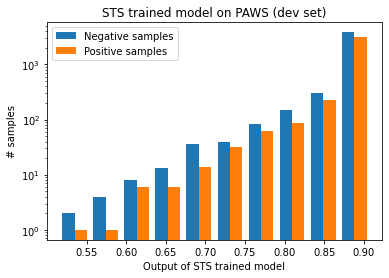

In [18]:
import matplotlib.pyplot as plt
import numpy as np

dev_pred = np.array(dev_pred)
dev_gold = np.array(dev_gold)
plt.hist([dev_pred[dev_gold == k] for k in [0, 1]], log='y')
plt.title('STS trained model on PAWS (dev set)')
plt.legend(['Negative samples', 'Positive samples'])
plt.xlabel('Output of STS trained model')
plt.ylabel('# samples')

In [13]:
from transformers import BertModel, BertTokenizer
sbert = BertModel.from_pretrained('sentence-transformers/bert-base-nli-cls-token')
sbert_token = BertTokenizer.from_pretrained('sentence-transformers/bert-base-nli-cls-token')

In [23]:
sbert(**sbert_token(['Hello world'], ['Hello world'], return_tensors='pt'))
#sbert.base_model

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.7820,  0.2361,  0.0953,  ...,  0.0895, -0.0735,  0.7291],
         [-0.7546,  0.2164,  0.9367,  ...,  0.0076, -0.0278,  0.2581],
         [-0.2837,  0.0139,  0.4588,  ...,  0.1102, -0.0616,  0.2473],
         ...,
         [-0.8114,  0.1433,  0.8264,  ...,  0.0843, -0.3883,  0.3078],
         [-0.2654,  0.1999,  0.6485,  ..., -0.1434, -0.4313,  0.1967],
         [ 0.3256, -0.0805,  0.4072,  ...,  0.5938, -0.2460, -0.2066]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-0.8601, -0.4748, -0.3709,  0.7743,  0.7137, -0.5542,  0.9498,  0.1424,
          0.0755, -0.9986, -0.0895,  0.8266,  0.8533,  0.1388,  0.9444, -0.8497,
         -0.7290, -0.5807,  0.4533, -0.7712,  0.6227,  0.9999, -0.0887,  0.1198,
          0.1411,  0.8625, -0.9238,  0.9428,  0.9152,  0.7683, -0.7814,  0.1612,
         -0.9646, -0.5027, -0.9285, -0.9684,  0.2071, -0.7986, -0.5763, -0.1284,
         -0.9623,  0.3751,  0.999